In [1]:
#Imports

import scipy.io
import pandas as pd
import os
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text, plot_tree
import matplotlib.pyplot as plt
from skimage import color
from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cie2000
import seaborn as sns

In [2]:
#Training view

mat = scipy.io.loadmat("DataSets_ASUS_OLED_GamingDisplay.mat")

training_rgb = pd.DataFrame(mat['TrainingRGB'], columns=['R', 'G', 'B'])
training_xyz = pd.DataFrame(mat['TrainingXYZ'], columns=['X', 'Y', 'Z'])
training_view = pd.concat([training_rgb, training_xyz], axis=1)

print(training_view.head())
print(training_view.describe())

   R  G   B         X         Y         Z
0  0  0   0  0.000000  0.000000  0.000000
1  0  0  12  0.001861  0.000941  0.005407
2  0  0  24  0.205943  0.006292  0.975375
3  0  0  36  0.352295  0.200939  2.794224
4  0  0  48  1.062900  0.493781  5.498844
                 R            G            B             X             Y  \
count  10648.00000  10648.00000  10648.00000  10648.000000  10648.000000   
mean     126.00000    126.00000    126.00000     49.037653     50.051643   
std       76.13504     76.13504     76.13504     28.455074     34.219215   
min        0.00000      0.00000      0.00000      0.000000      0.000000   
25%       60.00000     60.00000     60.00000     26.579440     21.542505   
50%      126.00000    126.00000    126.00000     45.052502     41.923553   
75%      192.00000    192.00000    192.00000     69.273787     75.638421   
max      252.00000    252.00000    252.00000    139.823649    148.288488   

                  Z  
count  10648.000000  
mean      56.166237

In [3]:
#Validation view

validation_rgb = pd.DataFrame(mat['ValidationRGB'], columns=['R', 'G', 'B'])
validation_xyz = pd.DataFrame(mat['ValidationXYZ'], columns=['X', 'Y', 'Z'])

validation_view = pd.concat([validation_rgb, validation_xyz], axis=1)

print(validation_view.head())
print(validation_view.describe())


   R  G   B         X         Y         Z
0  6  6   6  0.000000  0.000000  0.000000
1  6  6  18  0.089853  0.002745  0.425558
2  6  6  30  0.495926  0.332454  1.835895
3  6  6  42  0.907801  0.510769  4.058262
4  6  6  54  1.482858  0.755492  7.141147
                 R            G            B            X            Y  \
count  9261.000000  9261.000000  9261.000000  9261.000000  9261.000000   
mean    126.000000   126.000000   126.000000    47.447305    48.433074   
std      72.667532    72.667532    72.667532    27.163477    32.581070   
min       6.000000     6.000000     6.000000     0.000000     0.000000   
25%      66.000000    66.000000    66.000000    26.236756    21.315441   
50%     126.000000   126.000000   126.000000    43.589008    40.869331   
75%     186.000000   186.000000   186.000000    66.459863    72.912600   
max     246.000000   246.000000   246.000000   136.180084   139.150274   

                 Z  
count  9261.000000  
mean     54.183802  
std      48.093609

In [4]:
#xlsx

training_view.to_excel("training_view.xlsx", index=False)
validation_view.to_excel("validation_view.xlsx", index=False)

print("Minable views exported as 'training_view.xlsx' y 'validation_view.xlsx'")

Minable views exported as 'training_view.xlsx' y 'validation_view.xlsx'


In [5]:
#Model Construction

training_df = pd.read_excel("training_view.xlsx")
validation_df = pd.read_excel("validation_view.xlsx")

X_train = training_df[['R', 'G', 'B']]
y_train = training_df[['X', 'Y', 'Z']]
X_val = validation_df[['R', 'G', 'B']]
y_val = validation_df[['X', 'Y', 'Z']]

tree_x_deep = DecisionTreeRegressor(max_depth=15, random_state=42)
tree_y_deep = DecisionTreeRegressor(max_depth=15, random_state=42)
tree_z_deep = DecisionTreeRegressor(max_depth=15, random_state=42)

tree_x_deep.fit(X_train, y_train['X'])
tree_y_deep.fit(X_train, y_train['Y'])
tree_z_deep.fit(X_train, y_train['Z'])

pred_x_deep = tree_x_deep.predict(X_val)
pred_y_deep = tree_y_deep.predict(X_val)
pred_z_deep = tree_z_deep.predict(X_val)
y_pred_deep = np.stack([pred_x_deep, pred_y_deep, pred_z_deep], axis=1)

mse_x_deep = mean_squared_error(y_val['X'], pred_x_deep)
mse_y_deep = mean_squared_error(y_val['Y'], pred_y_deep)
mse_z_deep = mean_squared_error(y_val['Z'], pred_z_deep)

print(f"MSE X: {mse_x_deep:.2f}")
print(f"MSE Y: {mse_y_deep:.2f}")
print(f"MSE Z: {mse_z_deep:.2f}")


MSE X: 10.31
MSE Y: 11.62
MSE Z: 14.83


=== Reglas para predecir X (modelo profundo) ===
 |--- R <= 162.00
|   |--- G <= 162.00
|   |   |--- R <= 102.00
|   |   |   |--- B <= 162.00
|   |   |   |   |--- G <= 102.00
|   |   |   |   |   |--- B <= 102.00
|   |   |   |   |   |   |--- R <= 66.00
|   |   |   |   |   |   |   |--- G <= 66.00
|   |   |   |   |   |   |   |   |--- B <= 66.00
|   |   |   |   |   |   |   |   |   |--- R <= 42.00
|   |   |   |   |   |   |   |   |   |   |--- G <= 42.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- G >  42.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |--- R >  42.00
|   |   |   |   |   |   |   |   |   |   |--- R <= 54.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- R >  54.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   

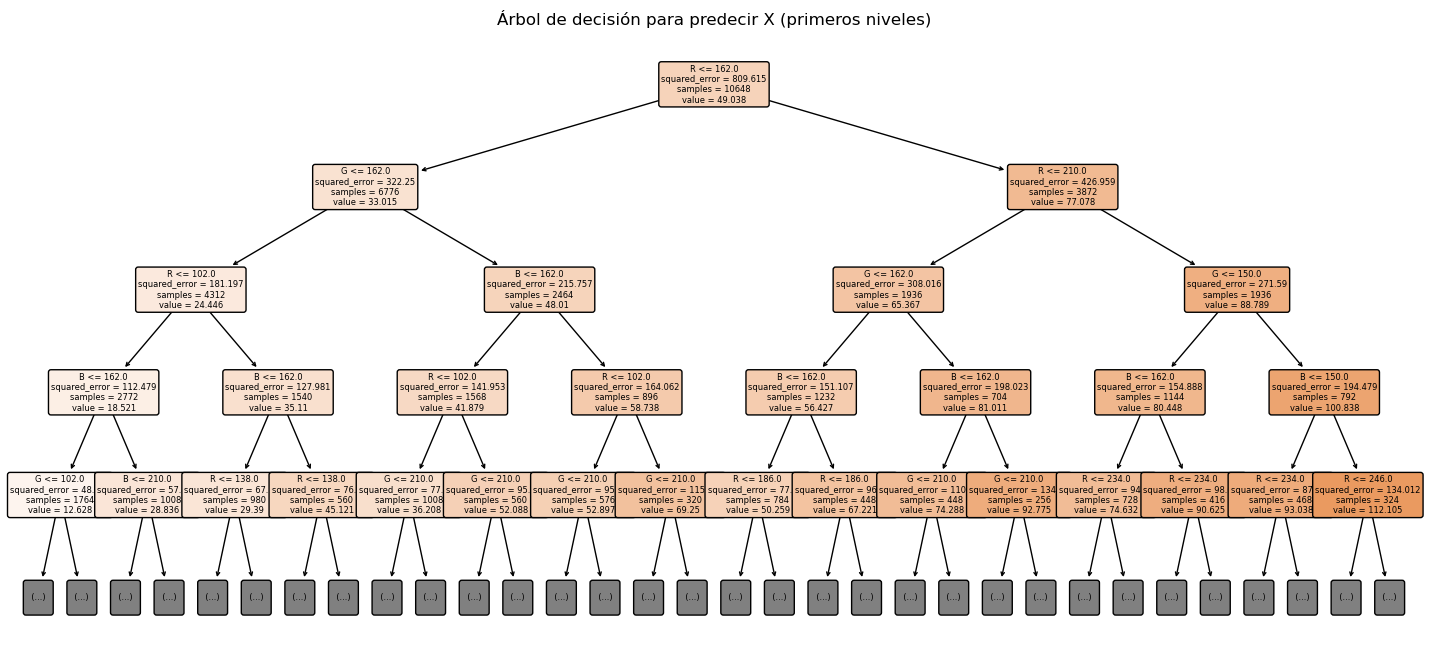

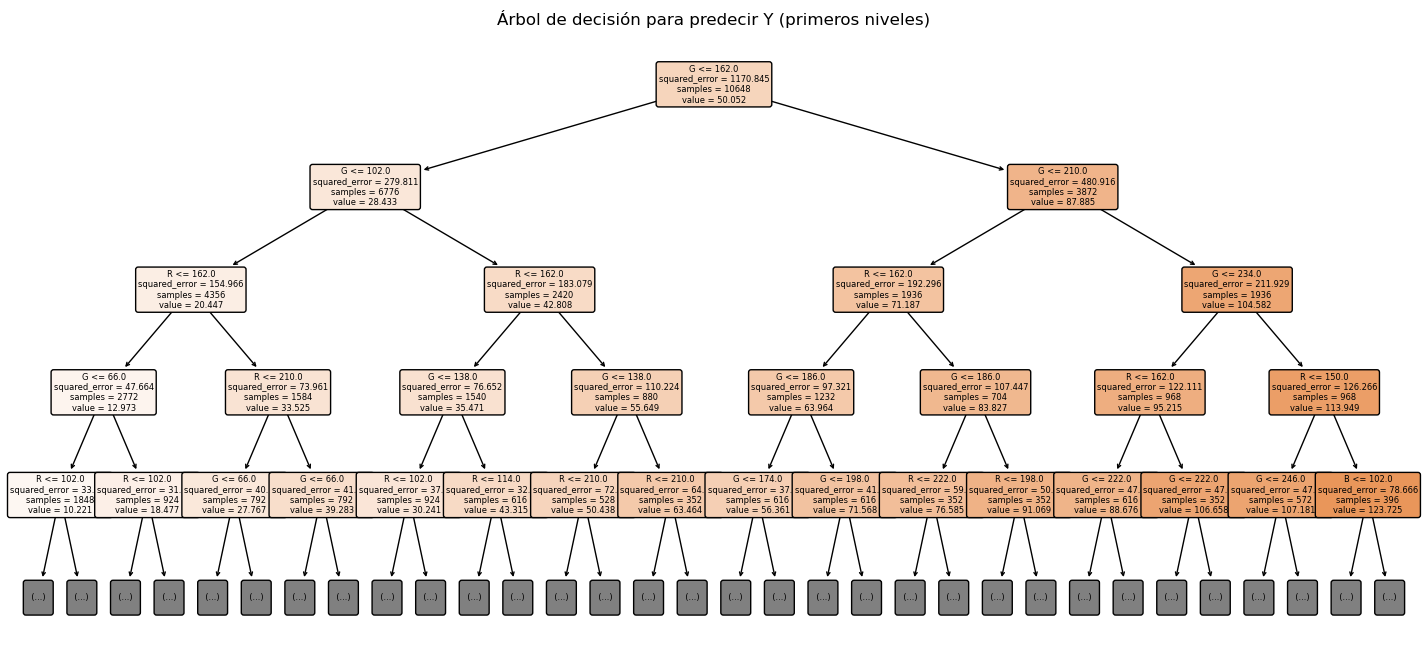

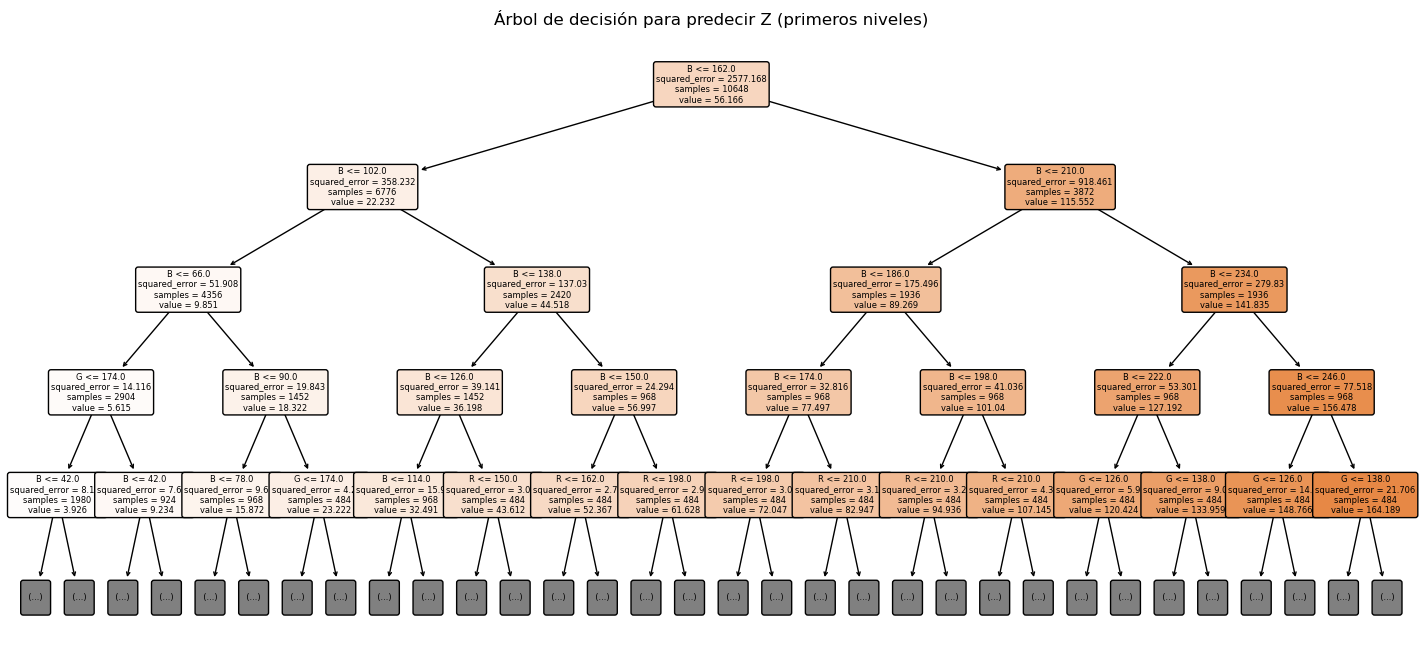

In [6]:
#Rule Extraction and Visualization

reglas_x_deep = export_text(tree_x_deep, feature_names=['R', 'G', 'B'], decimals=2)
reglas_y_deep = export_text(tree_y_deep, feature_names=['R', 'G', 'B'], decimals=2)
reglas_z_deep = export_text(tree_z_deep, feature_names=['R', 'G', 'B'], decimals=2)

print("=== Reglas para predecir X (modelo profundo) ===\n", reglas_x_deep)
print("\n=== Reglas para predecir Y (modelo profundo) ===\n", reglas_y_deep)
print("\n=== Reglas para predecir Z (modelo profundo) ===\n", reglas_z_deep)

plt.figure(figsize=(18, 8))
plot_tree(tree_x_deep, feature_names=['R', 'G', 'B'], filled=True, rounded=True, fontsize=6, max_depth=4)
plt.title("Árbol de decisión para predecir X (primeros niveles)")
plt.show()

plt.figure(figsize=(18, 8))
plot_tree(tree_y_deep, feature_names=['R', 'G', 'B'], filled=True, rounded=True, fontsize=6, max_depth=4)
plt.title("Árbol de decisión para predecir Y (primeros niveles)")
plt.show()

plt.figure(figsize=(18, 8))
plot_tree(tree_z_deep, feature_names=['R', 'G', 'B'], filled=True, rounded=True, fontsize=6, max_depth=4)
plt.title("Árbol de decisión para predecir Z (primeros niveles)")
plt.show()


In [7]:
#Model Evaluation
import numpy as np
np.asscalar = lambda a: a.item()  # Parche temporal para compatibilidad

lab_true_deep = color.xyz2lab(y_val.to_numpy())
lab_pred_deep = color.xyz2lab(y_pred_deep)

def compute_delta_e00_array(lab_true, lab_pred):
    delta_e = []
    for true, pred in zip(lab_true, lab_pred):
        c1 = LabColor(*true, observer='2', illuminant='d65')
        c2 = LabColor(*pred, observer='2', illuminant='d65')
        delta = delta_e_cie2000(c1, c2)
        delta_e.append(delta)
    return np.array(delta_e)

delta_e00_deep = compute_delta_e00_array(lab_true_deep, lab_pred_deep)

mean_deep = np.mean(delta_e00_deep)
std_deep = np.std(delta_e00_deep)
max_deep = np.max(delta_e00_deep)
perc_deep_over_2 = np.mean(delta_e00_deep > 2) * 100

print(f"Mean ∆E₀₀: {mean_deep:.2f}")
print(f"Std ∆E₀₀: {std_deep:.2f}")
print(f"Max ∆E₀₀: {max_deep:.2f}")
print(f"% of samples with ∆E₀₀ > 2: {perc_deep_over_2:.2f}%")


Mean ∆E₀₀: 2.10
Std ∆E₀₀: 2.21
Max ∆E₀₀: 77.13
% of samples with ∆E₀₀ > 2: 30.17%


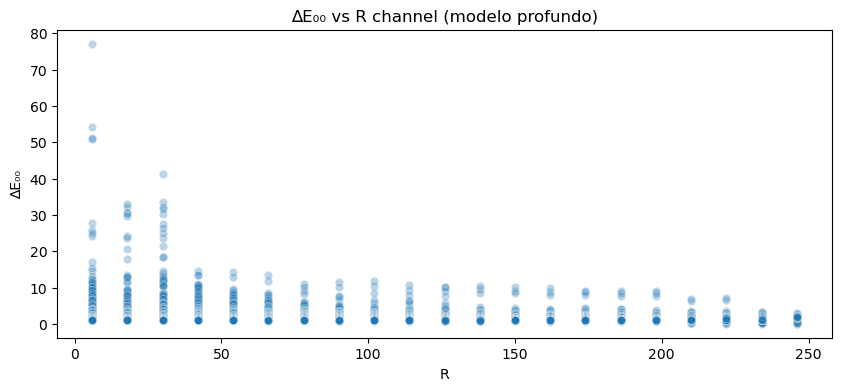

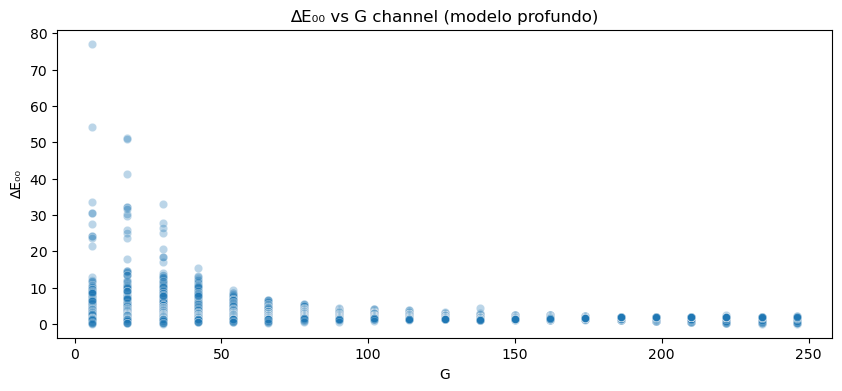

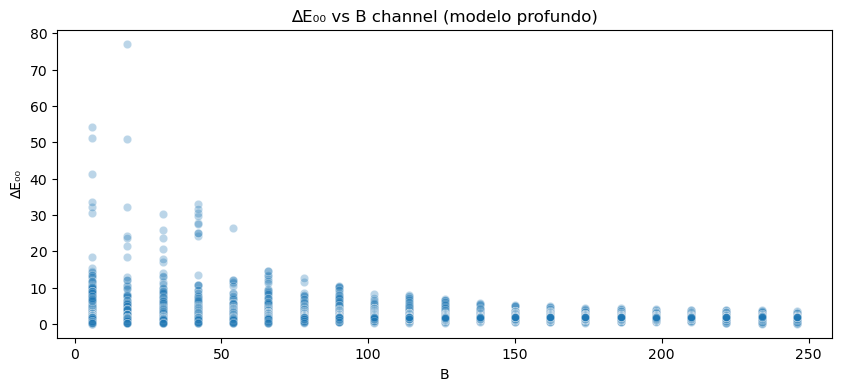

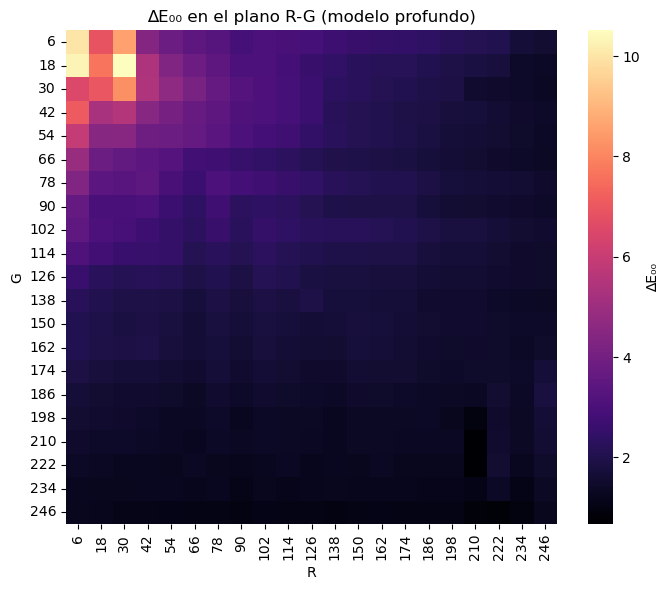

In [8]:
#Error Analysis and Interpretation

validation_df_deep_error = validation_df.copy()
validation_df_deep_error["DeltaE00"] = delta_e00_deep

plt.figure(figsize=(10, 4))
sns.scatterplot(data=validation_df_deep_error, x="R", y="DeltaE00", alpha=0.3)
plt.title("∆E₀₀ vs R channel (modelo profundo)")
plt.xlabel("R")
plt.ylabel("∆E₀₀")
plt.show()

plt.figure(figsize=(10, 4))
sns.scatterplot(data=validation_df_deep_error, x="G", y="DeltaE00", alpha=0.3)
plt.title("∆E₀₀ vs G channel (modelo profundo)")
plt.xlabel("G")
plt.ylabel("∆E₀₀")
plt.show()

plt.figure(figsize=(10, 4))
sns.scatterplot(data=validation_df_deep_error, x="B", y="DeltaE00", alpha=0.3)
plt.title("∆E₀₀ vs B channel (modelo profundo)")
plt.xlabel("B")
plt.ylabel("∆E₀₀")
plt.show()

plt.figure(figsize=(7, 6))
heatmap_data = validation_df_deep_error.pivot_table(
    values="DeltaE00", index="G", columns="R", aggfunc="mean"
)

sns.heatmap(heatmap_data, cmap="magma", cbar_kws={'label': '∆E₀₀'})
plt.title("∆E₀₀ en el plano R-G (modelo profundo)")
plt.xlabel("R")
plt.ylabel("G")
plt.tight_layout()
plt.show()



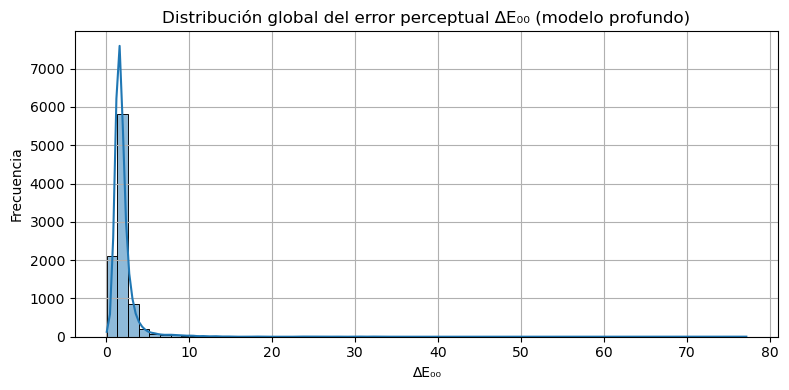

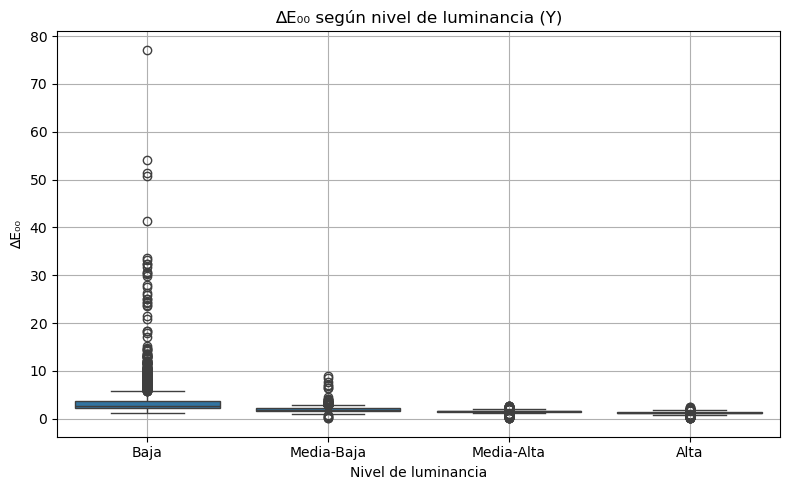

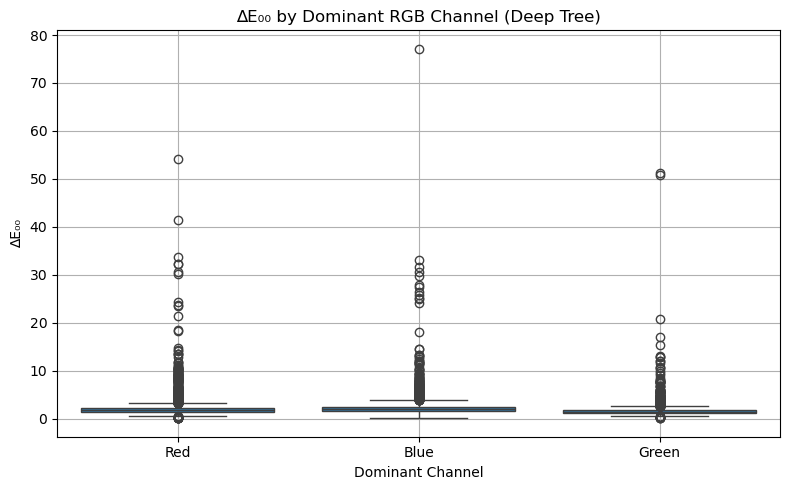

In [9]:
validation_df_deep_error = validation_df.copy()
validation_df_deep_error["DeltaE00"] = delta_e00_deep

plt.figure(figsize=(8, 4))
sns.histplot(validation_df_deep_error["DeltaE00"], bins=60, kde=True)
plt.title("Distribución global del error perceptual ∆E₀₀ (modelo profundo)")
plt.xlabel("∆E₀₀")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

validation_df_deep_error["Y_bin"] = pd.qcut(validation_df_deep_error["Y"], q=4, labels=["Baja", "Media-Baja", "Media-Alta", "Alta"])

plt.figure(figsize=(8, 5))
sns.boxplot(data=validation_df_deep_error, x="Y_bin", y="DeltaE00")
plt.title("∆E₀₀ según nivel de luminancia (Y)")
plt.xlabel("Nivel de luminancia")
plt.ylabel("∆E₀₀")
plt.grid(True)
plt.tight_layout()
plt.show()

def dominante(row):
    max_val = max(row["R"], row["G"], row["B"])
    if row["R"] == max_val:
        return "Red"
    elif row["G"] == max_val:
        return "Green"
    else:
        return "Blue"

validation_df_deep_error["DominantChannel"] = validation_df_deep_error.apply(dominante, axis=1)

plt.figure(figsize=(8, 5))
sns.boxplot(data=validation_df_deep_error, x="DominantChannel", y="DeltaE00")
plt.title("∆E₀₀ by Dominant RGB Channel (Deep Tree)")
plt.xlabel("Dominant Channel")
plt.ylabel("∆E₀₀")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': [5, 8, 10, 12, 15], 'min_samples_leaf': [1, 5, 10]}
best_models = {}

for target in ['X', 'Y', 'Z']:
    grid = GridSearchCV(
        DecisionTreeRegressor(random_state=42),
        params,
        scoring='neg_mean_squared_error',
        cv=3
    )
    grid.fit(X_train, y_train[target])
    best_models[target] = grid.best_estimator_
    print(f"Mejor modelo para {target}: {grid.best_params_}")


Mejor modelo para X: {'max_depth': 15, 'min_samples_leaf': 1}
Mejor modelo para Y: {'max_depth': 15, 'min_samples_leaf': 1}
Mejor modelo para Z: {'max_depth': 15, 'min_samples_leaf': 1}


In [11]:
from sklearn.ensemble import RandomForestRegressor

forest_x = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)
forest_y = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)
forest_z = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)

forest_x.fit(X_train, y_train['X'])
forest_y.fit(X_train, y_train['Y'])
forest_z.fit(X_train, y_train['Z'])

pred_x_forest = forest_x.predict(X_val)
pred_y_forest = forest_y.predict(X_val)
pred_z_forest = forest_z.predict(X_val)
y_pred_forest = np.stack([pred_x_forest, pred_y_forest, pred_z_forest], axis=1)

# Evaluación opcional con ∆E00 también


# Random Forest

In [13]:
import shap

# Crear un explainer para Random Forest
explainer_x = shap.TreeExplainer(forest_x)
explainer_y = shap.TreeExplainer(forest_y)
explainer_z = shap.TreeExplainer(forest_z)

# Calcular los valores SHAP para los conjuntos de validación
shap_values_x = explainer_x.shap_values(X_val)
shap_values_y = explainer_y.shap_values(X_val)
shap_values_z = explainer_z.shap_values(X_val)

# Visualización local para una instancia específica
shap.initjs()

# Utiliza explainer.expected_value como base para el gráfico
shap.force_plot(explainer_x.expected_value, shap_values_x[0], X_val.iloc[0])  # Para el modelo X
shap.force_plot(explainer_y.expected_value, shap_values_y[0], X_val.iloc[0])  # Para el modelo Y
shap.force_plot(explainer_z.expected_value, shap_values_z[0], X_val.iloc[0])  # Para el modelo Z


In [14]:
import lime
import lime.lime_tabular
import numpy as np

# Creación del explainer para Random Forest
explainer_x = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,  # Datos de entrenamiento
    feature_names=X_train.columns,  # Nombres de las características
    class_names=['X'],  # Nombre de la clase
    mode='regression'  # Ya que es un problema de regresión
)

explainer_y = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,  # Datos de entrenamiento
    feature_names=X_train.columns,  # Nombres de las características
    class_names=['Y'],  # Nombre de la clase
    mode='regression'  # Ya que es un problema de regresión
)

explainer_z = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,  # Datos de entrenamiento
    feature_names=X_train.columns,  # Nombres de las características
    class_names=['Z'],  # Nombre de la clase
    mode='regression'  # Ya que es un problema de regresión
)

# Selección de la instancia que deseas explicar (por ejemplo, la primera del conjunto de validación)
instance_x = X_val.iloc[0]
instance_y = X_val.iloc[0]
instance_z = X_val.iloc[0]

# Obtener la explicación para la instancia específica
explanation_x = explainer_x.explain_instance(instance_x.values, forest_x.predict)
explanation_y = explainer_y.explain_instance(instance_y.values, forest_y.predict)
explanation_z = explainer_z.explain_instance(instance_z.values, forest_z.predict)

# Visualización de las explicaciones
explanation_x.show_in_notebook(show_table=True, show_all=False)
explanation_y.show_in_notebook(show_table=True, show_all=False)
explanation_z.show_in_notebook(show_table=True, show_all=False)


C:\Users\pbala\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\pbala\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\pbala\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


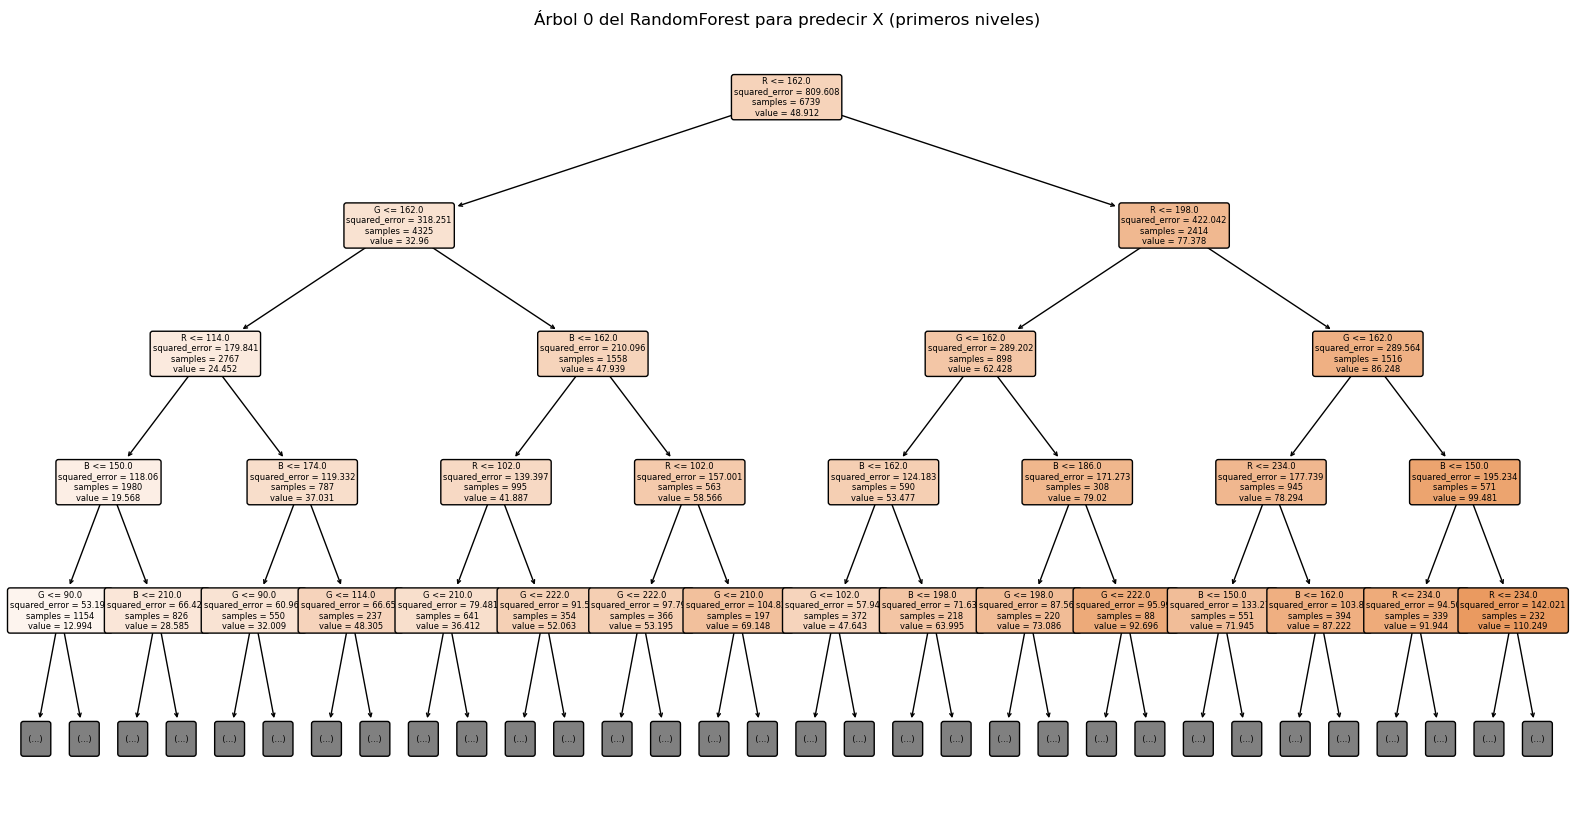

In [15]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Mostrar el primer árbol del bosque de X
plt.figure(figsize=(20, 10))
plot_tree(forest_x.estimators_[0], feature_names=['R', 'G', 'B'],
          filled=True, rounded=True, max_depth=4, fontsize=6)
plt.title("Árbol 0 del RandomForest para predecir X (primeros niveles)")
plt.show()


In [16]:
from sklearn.tree import export_text

tree_text = export_text(forest_x.estimators_[0], feature_names=['R', 'G', 'B'], decimals=2)
print("=== Reglas del Árbol 0 del Random Forest (X) ===")
print(tree_text)


=== Reglas del Árbol 0 del Random Forest (X) ===
|--- R <= 162.00
|   |--- G <= 162.00
|   |   |--- R <= 114.00
|   |   |   |--- B <= 150.00
|   |   |   |   |--- G <= 90.00
|   |   |   |   |   |--- R <= 78.00
|   |   |   |   |   |   |--- B <= 102.00
|   |   |   |   |   |   |   |--- R <= 54.00
|   |   |   |   |   |   |   |   |--- B <= 54.00
|   |   |   |   |   |   |   |   |   |--- G <= 54.00
|   |   |   |   |   |   |   |   |   |   |--- value: [1.74]
|   |   |   |   |   |   |   |   |   |--- G >  54.00
|   |   |   |   |   |   |   |   |   |   |--- value: [4.24]
|   |   |   |   |   |   |   |   |--- B >  54.00
|   |   |   |   |   |   |   |   |   |--- G <= 54.00
|   |   |   |   |   |   |   |   |   |   |--- value: [4.42]
|   |   |   |   |   |   |   |   |   |--- G >  54.00
|   |   |   |   |   |   |   |   |   |   |--- value: [6.90]
|   |   |   |   |   |   |   |--- R >  54.00
|   |   |   |   |   |   |   |   |--- G <= 54.00
|   |   |   |   |   |   |   |   |   |--- B <= 54.00
|   |   |   |   |   | 

In [17]:
import pandas as pd

feature_importance = pd.DataFrame({
    'Feature': ['R', 'G', 'B'],
    'Importance_X': forest_x.feature_importances_,
    'Importance_Y': forest_y.feature_importances_,
    'Importance_Z': forest_z.feature_importances_,
})

print(feature_importance)


  Feature  Importance_X  Importance_Y  Importance_Z
0       R      0.700722      0.097446      0.000694
1       G      0.198008      0.892484      0.001778
2       B      0.101270      0.010070      0.997529


In [18]:
lab_true_forest = color.xyz2lab(y_val.to_numpy())
lab_pred_forest = color.xyz2lab(y_pred_forest)
delta_e00_forest = compute_delta_e00_array(lab_true_forest, lab_pred_forest)

mean_forest = np.mean(delta_e00_forest)
std_forest = np.std(delta_e00_forest)
max_forest = np.max(delta_e00_forest)
perc_forest_over_2 = np.mean(delta_e00_forest > 2) * 100

print(f"Random Forest - Mean ∆E₀₀: {mean_forest:.2f}")
print(f"Random Forest - Std ∆E₀₀: {std_forest:.2f}")
print(f"Random Forest - Max ∆E₀₀: {max_forest:.2f}")
print(f"Random Forest - % of samples with ∆E₀₀ > 2: {perc_forest_over_2:.2f}%")


Random Forest - Mean ∆E₀₀: 3.35
Random Forest - Std ∆E₀₀: 4.93
Random Forest - Max ∆E₀₀: 115.76
Random Forest - % of samples with ∆E₀₀ > 2: 54.26%


# PLS

In [20]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from skimage import color
import numpy as np

# Modelo con 3 componentes latentes (ajustable)
pls_model = PLSRegression(n_components=3)
pls_model.fit(X_train, y_train)

# Predicción sobre el conjunto de validación
y_pred_pls = pls_model.predict(X_val)

# Métricas MSE por canal
mse_x_pls = mean_squared_error(y_val['X'], y_pred_pls[:, 0])
mse_y_pls = mean_squared_error(y_val['Y'], y_pred_pls[:, 1])
mse_z_pls = mean_squared_error(y_val['Z'], y_pred_pls[:, 2])

print(f"PLS MSE X: {mse_x_pls:.2f}")
print(f"PLS MSE Y: {mse_y_pls:.2f}")
print(f"PLS MSE Z: {mse_z_pls:.2f}")


PLS MSE X: 56.59
PLS MSE Y: 82.89
PLS MSE Z: 180.69


In [21]:
lab_true_pls = color.xyz2lab(y_val.to_numpy())
lab_pred_pls = color.xyz2lab(y_pred_pls)

delta_e00_pls = compute_delta_e00_array(lab_true_pls, lab_pred_pls)

print(f"Mean ∆E₀₀ (PLS): {np.mean(delta_e00_pls):.2f}")
print(f"Std ∆E₀₀ (PLS): {np.std(delta_e00_pls):.2f}")
print(f"Max ∆E₀₀ (PLS): {np.max(delta_e00_pls):.2f}")
print(f"% ∆E₀₀ > 2 (PLS): {np.mean(delta_e00_pls > 2) * 100:.2f}%")


Mean ∆E₀₀ (PLS): 23.45
Std ∆E₀₀ (PLS): 31.95
Max ∆E₀₀ (PLS): 268.88
% ∆E₀₀ > 2 (PLS): 99.65%


# Relaciones

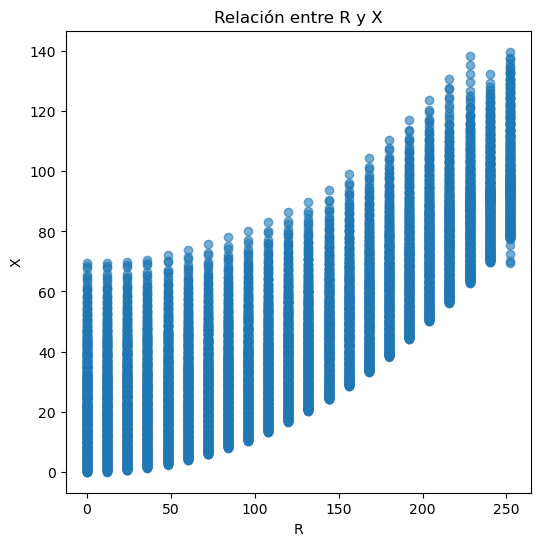

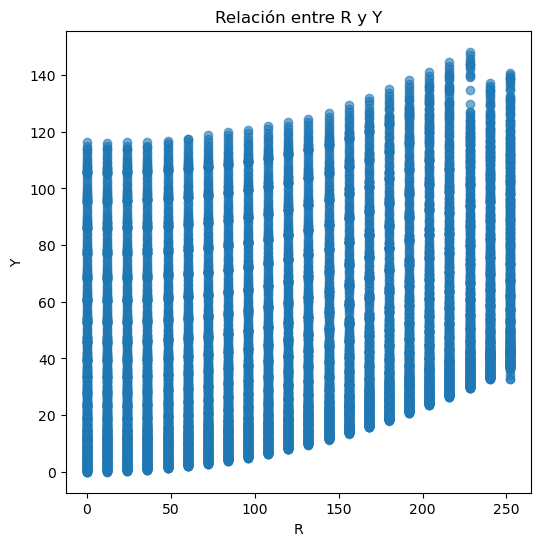

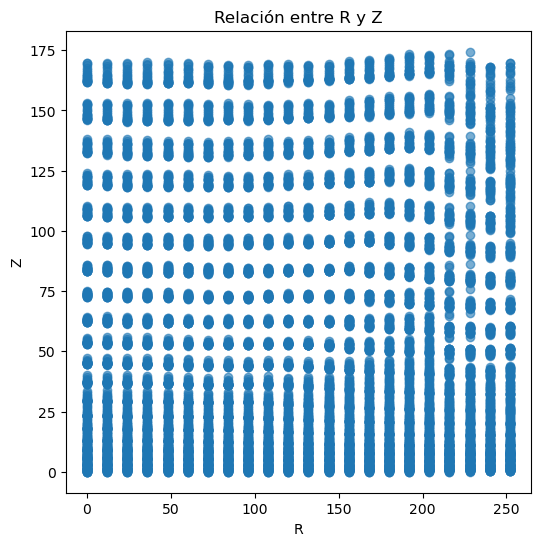

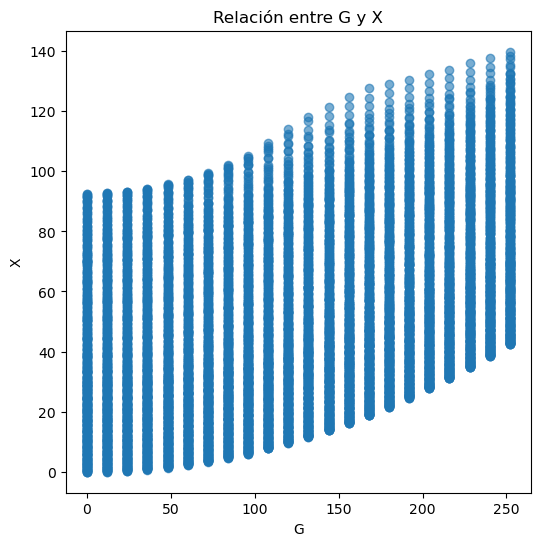

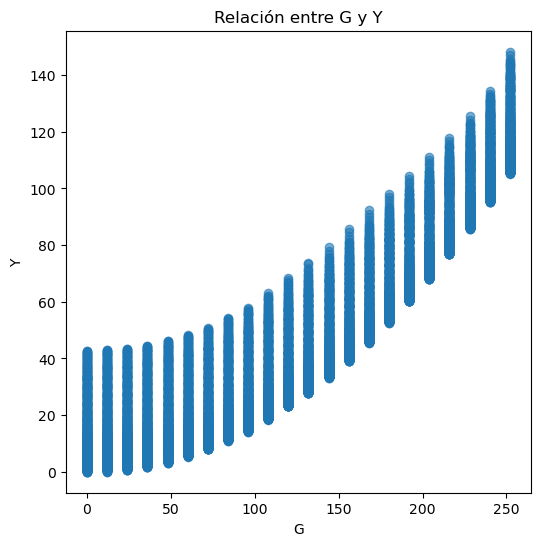

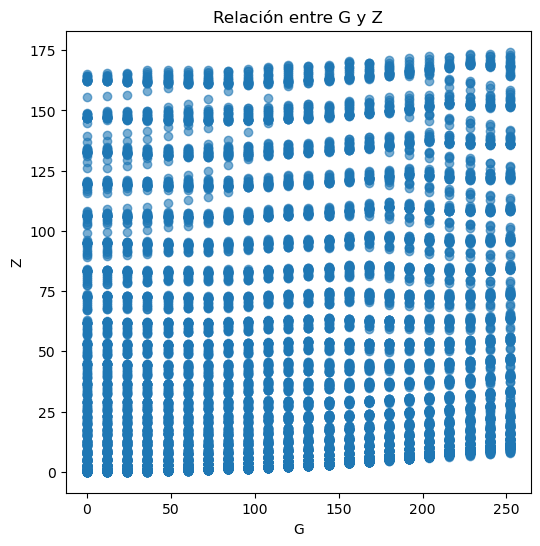

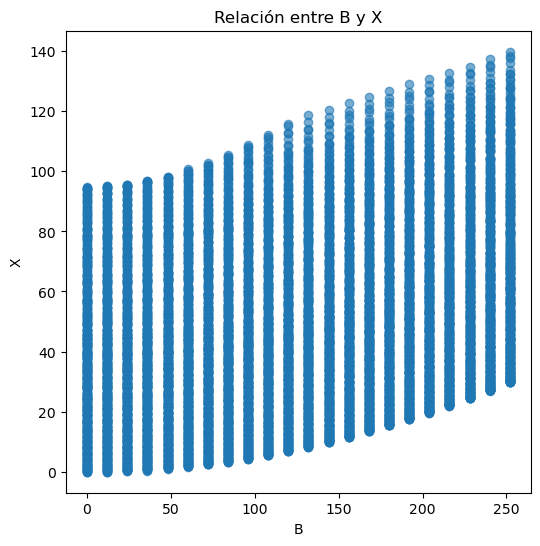

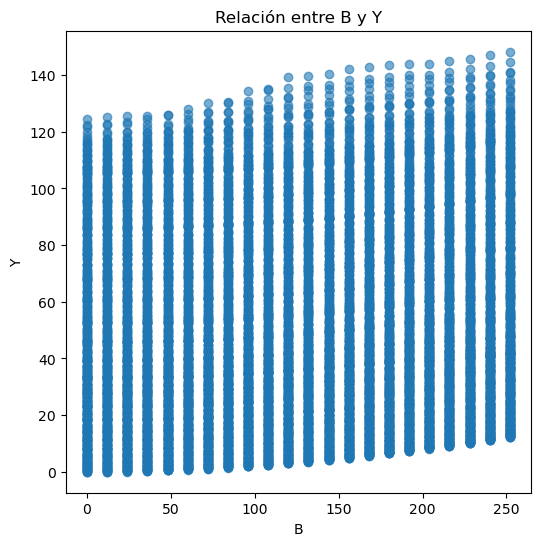

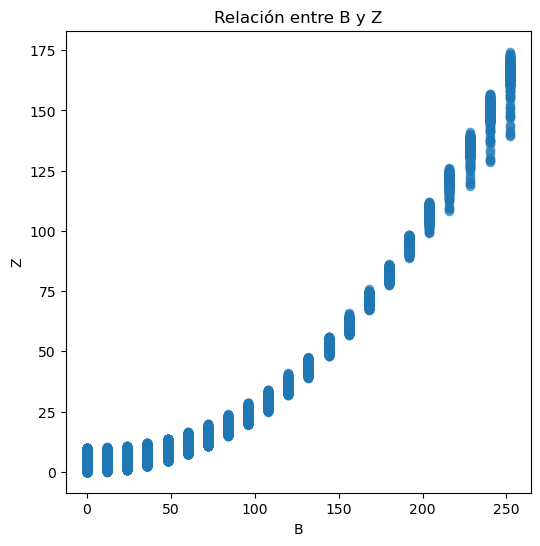

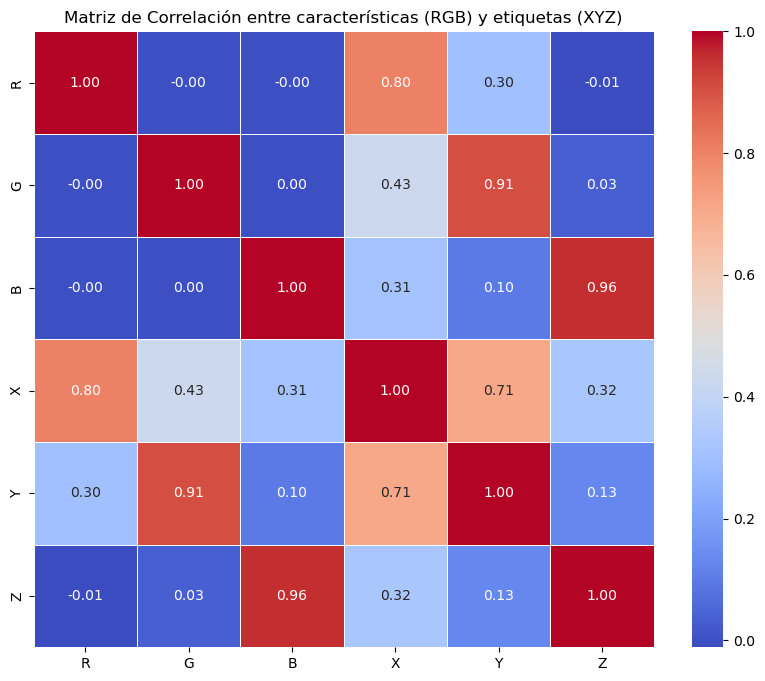

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Cargar los datos
training_df = pd.read_excel("training_view.xlsx")
validation_df = pd.read_excel("validation_view.xlsx")

# Función para graficar dispersión entre características y etiquetas
def plot_scatter_matrix(df, features, labels):
    """Genera gráficos de dispersión entre cada par de características y etiquetas"""
    for feature in features:
        for label in labels:
            plt.figure(figsize=(6, 6))
            plt.scatter(df[feature], df[label], alpha=0.6)
            plt.title(f"Relación entre {feature} y {label}")
            plt.xlabel(feature)
            plt.ylabel(label)
            plt.show()

# Características (R, G, B) y etiquetas (X, Y, Z)
features = ['R', 'G', 'B']
labels = ['X', 'Y', 'Z']

# Graficar dispersión para cada combinación de características y etiquetas
plot_scatter_matrix(training_df, features, labels)

# Matriz de correlación entre características y etiquetas
correlation_matrix = training_df[features + labels].corr()

# Graficar matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación entre características (RGB) y etiquetas (XYZ)")
plt.show()


# Matriz conversion

In [37]:
import numpy as np
import pandas as pd
import scipy.io
from sklearn.linear_model import LinearRegression
from math import sqrt

# Cargar los datos desde el archivo .mat
mat = scipy.io.loadmat("DataSets_ASUS_OLED_GamingDisplay.mat")
training_rgb = pd.DataFrame(mat['TrainingRGB'], columns=['R', 'G', 'B'])
training_xyz = pd.DataFrame(mat['TrainingXYZ'], columns=['X', 'Y', 'Z'])

# Normalizar y aplicar corrección gamma
def normalize_and_gamma(rgb_array):
    rgb_array = rgb_array / 255.0
    return np.where(rgb_array <= 0.04045, rgb_array / 12.92, ((rgb_array + 0.055) / 1.055) ** 2.4)

rgb_corrected = normalize_and_gamma(training_rgb.values)

# Aprender matriz de conversión personalizada
reg = LinearRegression(fit_intercept=False)
reg.fit(rgb_corrected, training_xyz.values)
custom_matrix = reg.coef_
print("Matriz personalizada RGB->XYZ:\n", custom_matrix)

# Función de conversión con matriz personalizada
def rgb_to_xyz_custom(rgb, matrix):
    rgb = np.array(rgb) / 255.0
    rgb = np.where(rgb <= 0.04045, rgb / 12.92, ((rgb + 0.055) / 1.055) ** 2.4)
    return np.dot(rgb, matrix.T)

# Función de ∆E en espacio XYZ
def delta_e_xyz(xyz1, xyz2):
    return sqrt(np.sum((np.array(xyz1) - np.array(xyz2))**2))


Matriz personalizada RGB->XYZ:
 [[ 8.07611206e+01  4.35318052e+01  3.18380663e+01]
 [ 3.69307949e+01  1.09319583e+02  1.30284418e+01]
 [-1.04575157e-01  7.91927258e+00  1.70822173e+02]]


In [38]:
# Aplicar la conversión a todos los RGB
converted_xyz = np.array([rgb_to_xyz_custom(rgb, custom_matrix) for rgb in training_rgb.values])

# Añadir resultados al DataFrame
training_view = pd.concat([training_rgb, training_xyz], axis=1)
training_view['X_converted'] = converted_xyz[:, 0]
training_view['Y_converted'] = converted_xyz[:, 1]
training_view['Z_converted'] = converted_xyz[:, 2]

# Calcular ∆E entre XYZ real y XYZ predicho
training_view['delta_e'] = training_view.apply(
    lambda row: delta_e_xyz([row['X'], row['Y'], row['Z']],
                            [row['X_converted'], row['Y_converted'], row['Z_converted']]),
    axis=1
)

# Mostrar resultados
print(training_view.head())
print("\n∆E promedio:", training_view['delta_e'].mean())


   R  G   B         X         Y         Z  X_converted  Y_converted  \
0  0  0   0  0.000000  0.000000  0.000000     0.000000     0.000000   
1  0  0  12  0.001861  0.000941  0.005407     0.117053     0.047899   
2  0  0  24  0.205943  0.006292  0.975375     0.290811     0.119003   
3  0  0  36  0.352295  0.200939  2.794224     0.561686     0.229847   
4  0  0  48  1.062900  0.493781  5.498844     0.941032     0.385079   

   Z_converted   delta_e  
0     0.000000  0.000000  
1     0.628029  0.634927  
2     1.560300  0.601700  
3     3.013637  0.304667  
4     5.048963  0.478603  

∆E promedio: 3.1421676343959595


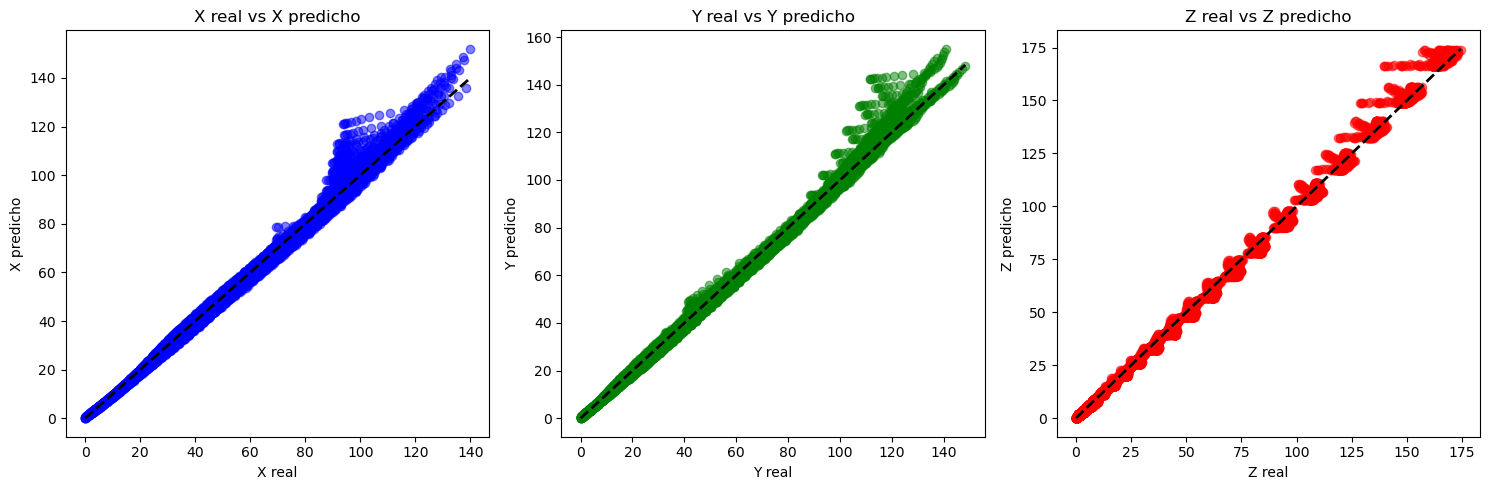

In [39]:
import matplotlib.pyplot as plt

# Graficar XYZ real vs XYZ predicho para cada componente (X, Y, Z)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# X component
axs[0].scatter(training_view['X'], training_view['X_converted'], color='blue', alpha=0.5)
axs[0].plot([min(training_view['X']), max(training_view['X'])], 
            [min(training_view['X']), max(training_view['X'])], 'k--', lw=2)
axs[0].set_title('X real vs X predicho')
axs[0].set_xlabel('X real')
axs[0].set_ylabel('X predicho')

# Y component
axs[1].scatter(training_view['Y'], training_view['Y_converted'], color='green', alpha=0.5)
axs[1].plot([min(training_view['Y']), max(training_view['Y'])], 
            [min(training_view['Y']), max(training_view['Y'])], 'k--', lw=2)
axs[1].set_title('Y real vs Y predicho')
axs[1].set_xlabel('Y real')
axs[1].set_ylabel('Y predicho')

# Z component
axs[2].scatter(training_view['Z'], training_view['Z_converted'], color='red', alpha=0.5)
axs[2].plot([min(training_view['Z']), max(training_view['Z'])], 
            [min(training_view['Z']), max(training_view['Z'])], 'k--', lw=2)
axs[2].set_title('Z real vs Z predicho')
axs[2].set_xlabel('Z real')
axs[2].set_ylabel('Z predicho')

plt.tight_layout()
plt.show()
